In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Подключаем папку с данными

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Набор метеорологических данных.
* Период записи наблюдения составляет 10 минут.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv", sep = ",", decimal = ".")
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


Функция организации временных интервалов

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации

In [5]:
TRAIN_SPLIT = 300000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [6]:
tf.random.set_seed(13)

**Прогнозирование на основе одномерного временного ряда**

Извлечем только температуру из набора данных

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
                       ... 
31.12.2016 23:20:00   -4.05
31.12.2016 23:30:00   -3.35
31.12.2016 23:40:00   -3.16
31.12.2016 23:50:00   -4.23
01.01.2017 00:00:00   -4.82
Name: T (degC), Length: 420551, dtype: float64

Отобразим данные на графике

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6663d7fc10>],
      dtype=object)

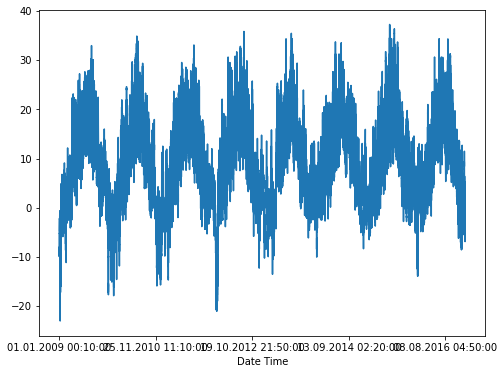

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

Маштабирование данных.

Выполним стандартизацию набора данных с вычислением среднего значения и стандартного отклонения обучающих данных

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Выполним стандартизацию данных

In [11]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Далее подготовим данные для модели с одномерным входом.

На вход в модель будут подаваться последние 20 наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге.

In [12]:
univariate_past_history = 20
univariate_future_target = 0
# Тестовая
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
# Валидационая
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

Результаты применения функции `univariate_data`

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


Представим данные в виде графика

In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

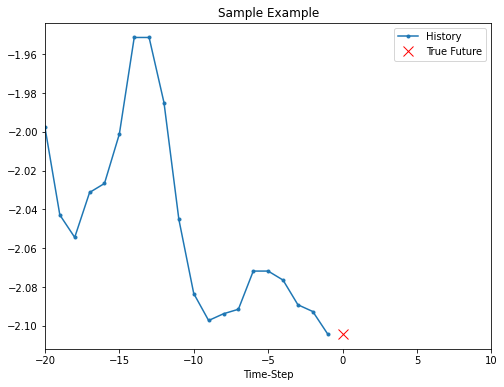

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

**Рекуррентная нейронная сеть**

LSTM «Долгая краткосрочная память»

In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [17]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Проверим выход модели

In [18]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 1s 5ms/step
(256, 1)


Обучением модели

In [19]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 6s 18ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0227 - val_lo

Выполним несколько прогнозов

8/8 [==============================] - 0s 4ms/step


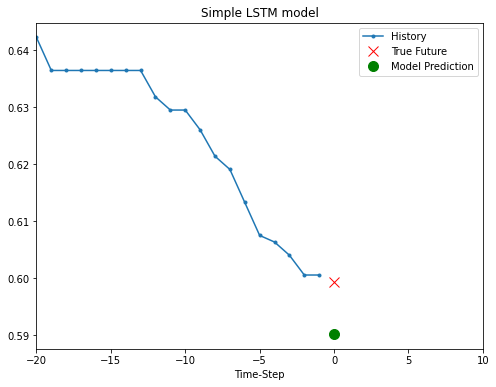

8/8 [==============================] - 0s 4ms/step


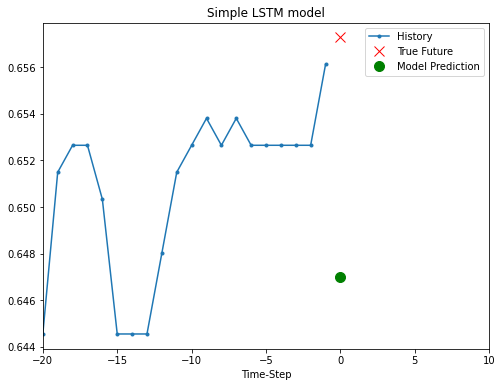

8/8 [==============================] - 0s 4ms/step


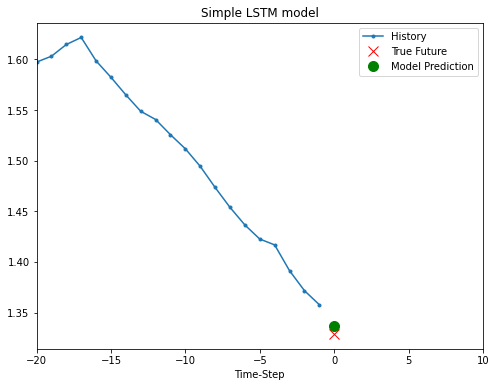

In [20]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

**Прогнозирование на основе многомерного временного ряда**

Извлечем давление, температуру и плотность воздуха из набора данных

In [21]:
features = df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Отобразим данные на графике

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6662c8aa30>,
      dtype=object)

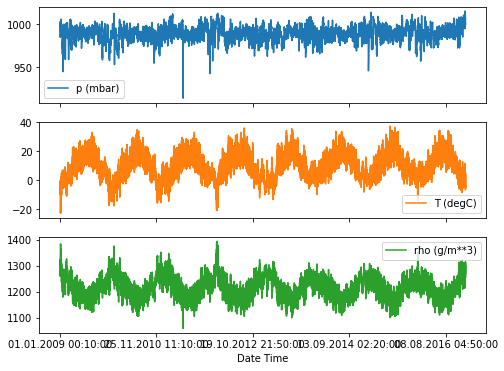

In [22]:
features.plot(subplots=True)

Маштабирование данных.

Выполним стандартизацию набора данных с вычислением среднего значения и стандартного отклонения обучающих данных

In [23]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

Выполним стандартизацию данных

In [24]:
dataset = (dataset-data_mean)/data_std

Точечное прогнозирование.

Функция организации временных интервалов

In [25]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

В данном наборе данные за последние пять (5) дней (6 х 24 х 5 = 720). Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет составлять температура после 72 (12х6) наблюдений.

In [26]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

Результаты применения функции `multivariate_data`

In [27]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


**Рекуррентная нейронная сеть**

In [28]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [29]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [30]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 1s 13ms/step
(256, 1)


Обучением модели

In [31]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 27s 122ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 26s 129ms/step - loss: 0.2623 - val_loss: 0.2422
Epoch 3/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2613 - val_loss: 0.2477
Epoch 4/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2567 - val_loss: 0.2439
Epoch 5/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2259 - val_loss: 0.2372
Epoch 6/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2416 - val_loss: 0.2667
Epoch 7/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2405 - val_loss: 0.2555
Epoch 8/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2399 - val_loss: 0.2394
Epoch 9/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2450 - val_loss: 0.2454
Epoch 10/10
200/200 [==============================] - 24s 120ms/step - l

Выведим график потерь

In [32]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

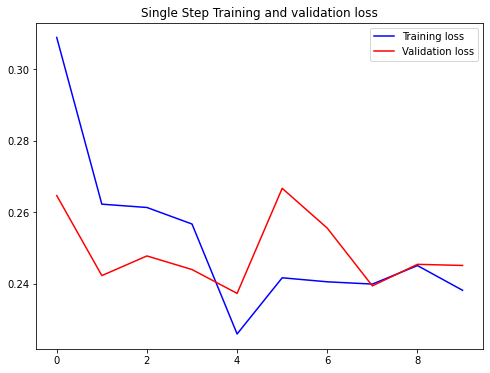

In [33]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

**Выполнение точечного прогноза**

Выполним несколько прогнозов

8/8 [==============================] - 0s 14ms/step


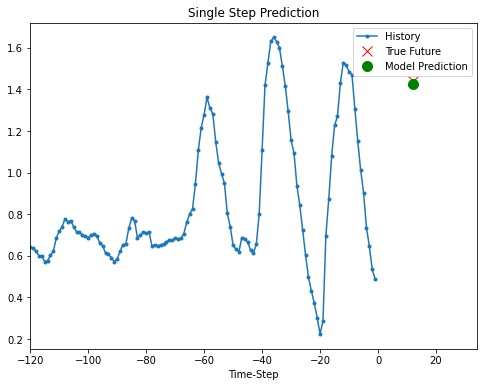

8/8 [==============================] - 0s 13ms/step


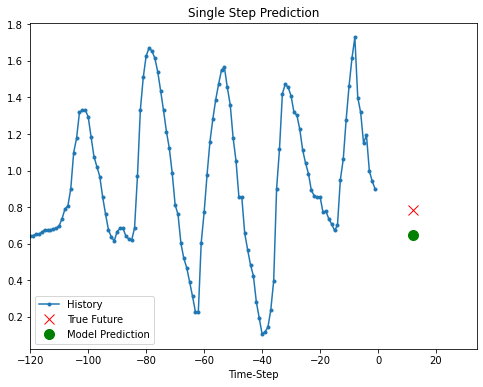

8/8 [==============================] - 0s 13ms/step


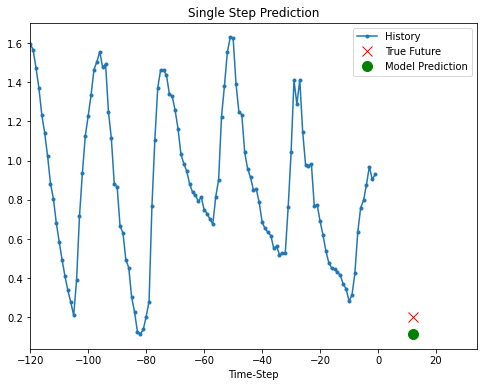

In [36]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, 'Single Step Prediction')
  plot.show()

**Интервальное прогнозирование**

In [37]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP)

Проверим выборку

In [38]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [39]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Подготовим визуализацию

In [40]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

На этом и последующих аналогичных графиках история и будущие данные ежечасные

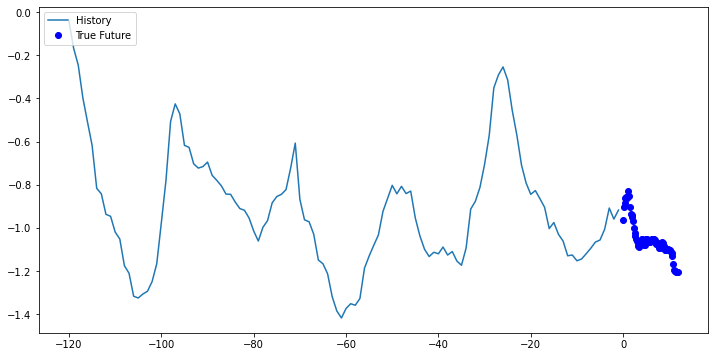

In [41]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 72 прогноза, выход слой насчитывает 72 нейрона.

In [42]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [43]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 22ms/step
(256, 72)


In [44]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 52s 236ms/step - loss: 0.4951 - val_loss: 0.2979
Epoch 2/10
200/200 [==============================] - 44s 220ms/step - loss: 0.3465 - val_loss: 0.2832
Epoch 3/10
200/200 [==============================] - 44s 220ms/step - loss: 0.3301 - val_loss: 0.2415
Epoch 4/10
200/200 [==============================] - 45s 225ms/step - loss: 0.2454 - val_loss: 0.2068
Epoch 5/10
200/200 [==============================] - 45s 225ms/step - loss: 0.1992 - val_loss: 0.2004
Epoch 6/10
200/200 [==============================] - 45s 225ms/step - loss: 0.2077 - val_loss: 0.2099
Epoch 7/10
200/200 [==============================] - 47s 236ms/step - loss: 0.1984 - val_loss: 0.2088
Epoch 8/10
200/200 [==============================] - 45s 227ms/step - loss: 0.1957 - val_loss: 0.1956
Epoch 9/10
200/200 [==============================] - 48s 239ms/step - loss: 0.1974 - val_loss: 0.1886
Epoch 10/10
200/200 [==============================] - 44s 221ms/step - l

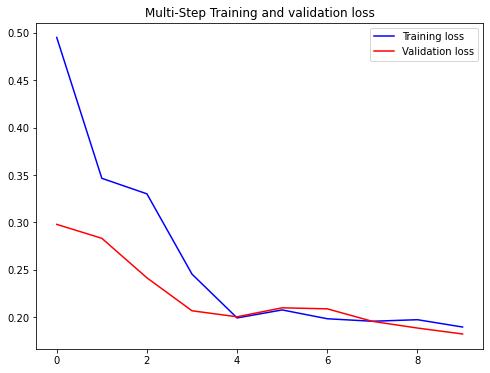

In [45]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

**Выполнение интервального прогноза**

Прогноз будущих значений температуры

8/8 [==============================] - 0s 26ms/step


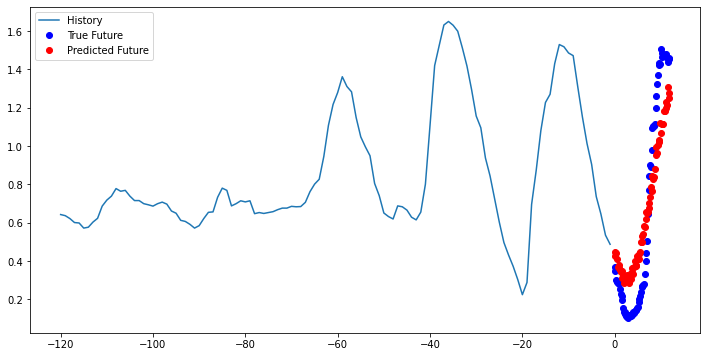

8/8 [==============================] - 0s 24ms/step


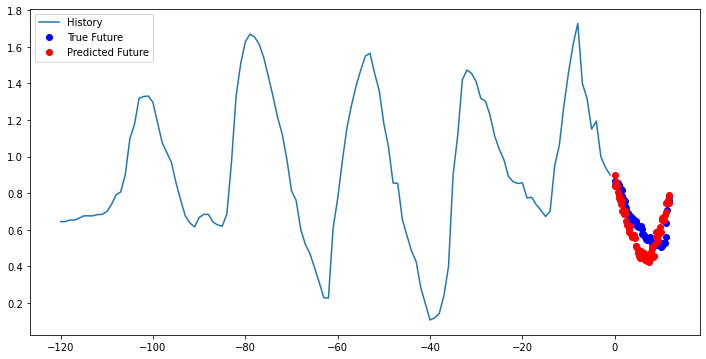

8/8 [==============================] - 0s 23ms/step


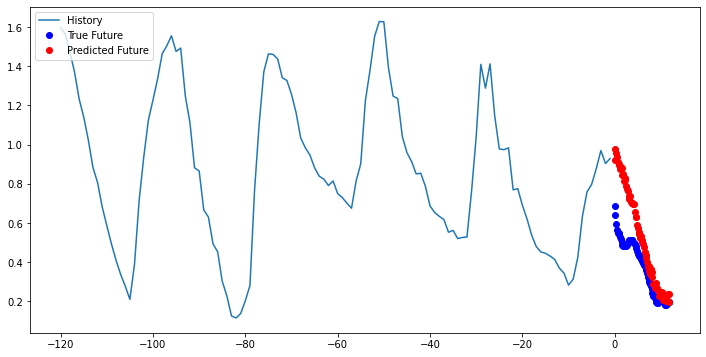

In [46]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])